In [1]:
import json

import agama
import gizmo_analysis as gizmo  # rename these packages for brevity
import numpy as np
import utilities as ut  # rename these packages for brevity

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
full_snap = np.array(
    [
        20,
        23,
        26,
        29,
        33,
        37,
        41,
        46,
        52,
        59,
        67,
        77,
        88,
        102,
        120,
        142,
        172,
        214,
        277,
        294,
        312,
        332,
        356,
        382,
        412,
        446,
        486,
        534,
        590,
        591,
        592,
        593,
        594,
        595,
        596,
        597,
        598,
        599,
        600,
    ],
    dtype=int,
)

In [3]:
simulation_directory = "/Volumes/My Passport for Mac/m12i_res7100"
# simulation_directory = "/Users/z5114326/Documents/SampleData/m12i_res7100"

# idx = full_snap[-11] # recheck
# idx = full_snap[-12] # recheck
# idx = full_snap[-13] # recheck
# idx = full_snap[-16] # recheck
idx = full_snap[-19]

part = gizmo.io.Read.read_snapshots("all", "index", idx, simulation_directory, assign_hosts_rotation=True)


# in utilities.simulation.Snapshot():
* reading:  Volumes/My Passport for Mac/m12i_res7100/snapshot_times.txt

  using snapshot index = 312, redshift = 0.799


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  Volumes/My Passport for Mac/m12i_res7100/output/snapdir_312/snapshot_312.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 64782308 particles
    star      (id = 4): 5800735 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['dark', 'dark2', 'gas', 'star']

* reading particles from:
    snapshot_312.0.hdf5
    snapshot_312.1.hdf5
    snapshot_312.2.hdf5
    snapshot_312.3.hdf5

* reading cosmological parameters from:  Volumes/My Passport for Mac/m12i_res7100/initial_condition/ic_agora_m12i.conf

* checking sanity of particle properties
! warning: gas mass [min, med, max] = [7067.277, 7067.277, 1.256e5]


# in gizmo_an

In [6]:
def plot_image(
    part,
    species_name="star",
    weight_name="mass",
    part_indices=None,
    dimensions_plot=[0, 1],
    distance_max=20,
    distance_bin_width=0.1,
    rotation=True,
    host_index=0,
    image_limits=[None, None],
):
    """
    Plot 2-D projected image of the positions of given partcle species.

    Parameters
    ----------
    part : dict
        catalog of particles at snapshot
    species_name : str
        name of particle species to plot
    weight_name : str
        property to weight positions by
    part_indices : array
        input selection indices for particles
    dimensions_plot : list
        spatial dimensions to plot
    distance_max : float or array
        maximum distance from center to plot [kpc]
    distance_bin_width : float
        size of pixel [kpc]
    rotation : bool or array
        whether to rotate particles
        if True, will rotate to align with principal axes defined by input species
    host_index : int
        index of host halo to get position and rotation of (if not input them)
    image_limits : list
        min and max limits to impose on image dynamic range (exposure)
    """
    from matplotlib import colors

    dimen_label = {0: "x", 1: "y", 2: "z"}

    # get distance limits for plot
    position_limits = [[-distance_max, distance_max] for _ in range(2)]
    position_limits = np.array(position_limits)

    # get array of particle indices (if not input)
    if part_indices is None or len(part_indices) == 0:
        part_indices = ut.array.get_arange(part[species_name]["position"].shape[0])

    # get positions relative to host galaxy center
    host_name = ut.catalog.get_host_name(host_index)
    if rotation is True:
        # rotate according to principal axes
        positions = part[species_name].prop(f"{host_name}.distance.principal", part_indices)
    else:
        # positions in (arbitrary) Cartesian x,y,z of simulation
        positions = part[species_name].prop(f"{host_name}.distance", part_indices)

    # weight particles by some property?
    weights = None
    if weight_name:
        weights = part[species_name].prop(weight_name, part_indices)

    # keep only particles within distance limits along each dimension
    masks = positions[:, dimensions_plot[0]] <= distance_max
    for dimen_i in dimensions_plot:
        masks *= (positions[:, dimen_i] >= -distance_max) * (positions[:, dimen_i] <= distance_max)

    # keep only positions and weights within distance limits
    positions = positions[masks]
    if weights is not None:
        weights = weights[masks]

    # get number of bins (pixels) along each dimension
    position_bin_number = int(np.round(2 * np.max(distance_max) / distance_bin_width))

    # get 2-D histogram
    hist_valuess, hist_xs, hist_ys = np.histogram2d(
        positions[:, dimensions_plot[0]],
        positions[:, dimensions_plot[1]],
        position_bin_number,
        position_limits,
        weights=weights,
    )
    # convert to surface density
    hist_valuess /= np.diff(hist_xs)[0] * np.diff(hist_ys)[0]

    # set color map
    if "dark" in species_name:
        color_map = plt.cm.afmhot
    elif species_name == "gas":
        color_map = plt.cm.afmhot
    elif species_name == "star":
        color_map = plt.cm.afmhot

    fig = plt.figure()
    subplot = fig.add_subplot(111, facecolor="black")

    subplot.set_xlim(position_limits[0])
    subplot.set_ylim(position_limits[1])

    subplot.set_xlabel(f"{dimen_label[dimensions_plot[0]]} $\\left[ {{\\rm kpc}} \\right]$")
    subplot.set_ylabel(f"{dimen_label[dimensions_plot[1]]} $\\left[ {{\\rm kpc}} \\right]$")

    # make 2-D histogram image
    Image = subplot.imshow(
        hist_valuess.transpose(),
        norm=colors.LogNorm(),
        cmap=color_map,
        aspect="auto",
        interpolation="bilinear",
        extent=np.concatenate(position_limits),
        vmin=image_limits[0],
        vmax=image_limits[1],
    )

    fig.colorbar(Image)

    plt.show(block=False)


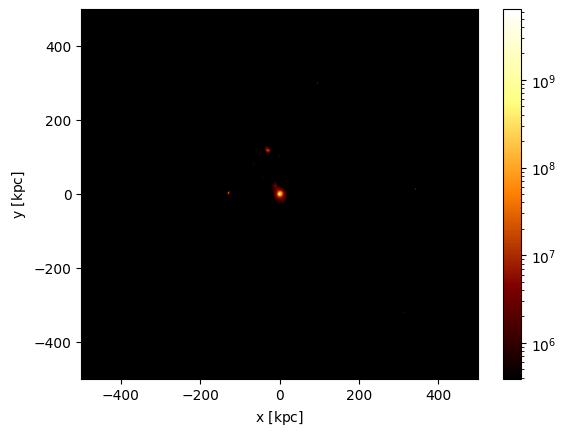

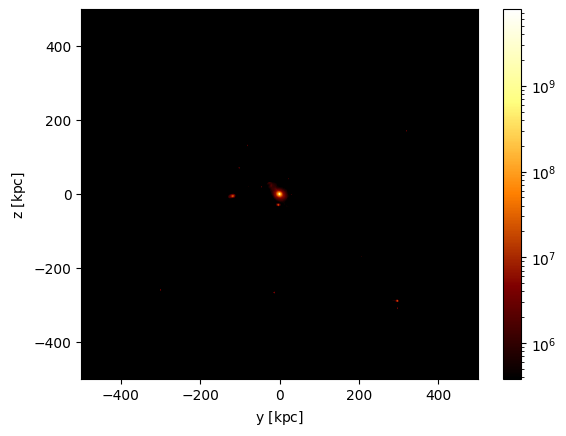

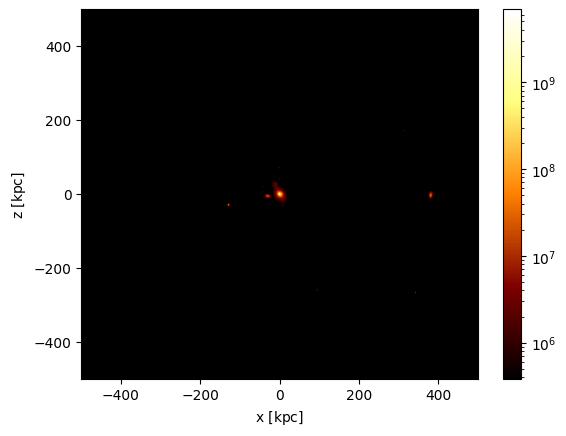

In [30]:
distance = 500
plot_image(part, "star", dimensions_plot=[0, 1], distance_max=distance)
plot_image(part, "star", dimensions_plot=[1, 2], distance_max=distance)
plot_image(part, "star", dimensions_plot=[0, 2], distance_max=distance)

In [19]:
pos_limit_bary = 175  # was 200
pos_limit_dark = 600  # was 600

# 900 good

bary_pos_hold = []
bary_mass_hold = []

bary_ptypes = ["star", "gas"]

for ptype in bary_ptypes:
    position_lst = part[ptype].prop("host1.distance.total")
    mask = position_lst < pos_limit_bary
    bary_pos_hold.append(np.array(part[ptype].prop("host1.distance.principal", mask)))
    bary_mass_hold.append(np.array(part[ptype]["mass"][mask]))

bary_pos_args = (bary_pos_hold[0], bary_pos_hold[1])
bary_pos = np.concatenate(bary_pos_args)

bary_mass_args = (bary_mass_hold[0], bary_mass_hold[1])
bary_mass = np.concatenate(bary_mass_args)

In [20]:
dark_pos_hold = []
dark_mass_hold = []

dark_ptypes = ["dark", "dark2"]

for ptype in dark_ptypes:
    position_lst = part[ptype].prop("host1.distance.total")
    mask = position_lst < pos_limit_dark
    dark_pos_hold.append(np.array(part[ptype].prop("host1.distance.principal", mask)))
    dark_mass_hold.append(np.array(part[ptype]["mass"][mask]))

dark_pos_args = (dark_pos_hold[0], dark_pos_hold[1])
dark_pos = np.concatenate(dark_pos_args)

dark_mass_args = (dark_mass_hold[0], dark_mass_hold[1])
dark_mass = np.concatenate(dark_mass_args)

In [21]:
units = {"length": 1, "velocity": 1, "mass": 1}

component_1 = {
    # "pos_limit": pos_limit_dark,
    # "ptypes": ["dark", "dark2"],
    "type": "Multipole",
    "symmetry": "axisymmetric",
    "lmax": 2,
    "mmax": 0,
    "gridSizeR": 20,
}

component_2 = {
    # "pos_limit": pos_limit_bary,
    # "ptypes": ["star", "gas"],
    "type": "CylSpline",
    "symmetry": "axisymmetric",
    "mmax": 0,
    "gridSizeR": 20,
    "gridSizeZ": 20,
}

component_2 = {
    # "pos_limit": pos_limit_bary,
    # "ptypes": ["star", "gas"],
    "type": "Multipole",
    "symmetry": "axisymmetric",
    "lmax": 2,
    "mmax": 0,
    "gridSizeR": 20,
}


agama.setUnits(**units)

pot_nbody_dark = agama.Potential(**component_1, particles=(dark_pos, dark_mass))
pot_nbody_bary = agama.Potential(**component_2, particles=(bary_pos, bary_mass))

component_1["pos_limit"] = pos_limit_dark
component_1["ptypes"] = ["dark", "dark2"]

component_2["pos_limit"] = pos_limit_bary
component_2["ptypes"] = ["star", "gas"]

pot_nbody = agama.Potential(pot_nbody_dark, pot_nbody_bary)  # combine components into single potential

print(pot_nbody)

CompositePotential{ Multipole, Multipole } (symmetry: Axisymmetric)


In [22]:
gridR = agama.nonuniformGrid(500, 0.01, 1000)
gridz = agama.symmetricGrid(500, 0.01, 1000)
grid2R, grid2z = np.meshgrid(gridR, gridz)
gridRz = np.column_stack((grid2R.reshape(-1), grid2z.reshape(-1)))
gridx0z = np.column_stack((grid2R.reshape(-1), grid2R.reshape(-1) * 0, grid2z.reshape(-1)))
gridR00 = np.column_stack((gridR, gridR * 0, gridR * 0))
grid00z = np.column_stack((gridz * 0, gridz * 0, gridz))

In [23]:
pos_hold = []
cyl_hold = []
mass_hold = []

pos_limit_part = 1000

for ptype in part.keys():
    position_lst = part[ptype].prop("host1.distance.total")
    mask = position_lst < pos_limit_part
    pos_hold.append(np.array(part[ptype].prop("host1.distance.principal", mask)))
    cyl_hold.append(np.array(part[ptype].prop("host.distance.principal.cylindrical", mask)))
    mass_hold.append(np.array(part[ptype]["mass"][mask]))

pos_args = (pos_hold[0], pos_hold[1], pos_hold[2], pos_hold[3])
pos_base = np.concatenate(pos_args)

cyl_args = (cyl_hold[0], cyl_hold[1], cyl_hold[2], cyl_hold[3])
cyl_base = np.concatenate(cyl_args)

mass_args = (mass_hold[0], mass_hold[1], mass_hold[2], mass_hold[3])
mass_base = np.concatenate(mass_args)

In [24]:
def radial_dens(rad_set, z_set, r_bin_size, z_bin_size, cyl_base, mass_base):
    r_min, r_max = rad_set - r_bin_size / 2, rad_set + r_bin_size / 2
    z_min, z_max = z_set - z_bin_size / 2, z_set + z_bin_size / 2

    r_lst = cyl_base[:, 0]
    z_lst = cyl_base[:, 2]

    mask = np.where((r_lst >= r_min) & (r_lst <= r_max) & (z_lst >= z_min) & (z_lst <= z_max))
    mass_test = mass_base[mask]

    mas = np.sum(mass_test)
    vol = z_bin_size * np.pi * (r_max**2 - r_min**2)
    density = mas / vol

    return density

In [25]:
def z_dens(z_set, z_bin_size, r_min, r_max, cyl_base, mass_base):
    z_min, z_max = z_set - z_bin_size / 2, z_set + z_bin_size / 2

    r_lst = cyl_base[:, 0]
    z_lst = cyl_base[:, 2]

    mask = np.where((r_lst >= r_min) & (r_lst <= r_max) & (abs(z_lst) >= z_min) & (abs(z_lst) <= z_max))
    mass_test = mass_base[mask]

    mas = np.sum(mass_test)
    vol = 2 * z_bin_size * np.pi * (r_max**2 - r_min**2)
    density = mas / vol

    return density

In [26]:
bin_num = 50

rad_lst = np.logspace(-2, 3.5, bin_num)
# rad_lst = np.logspace(-2, 2, bin_num)
rad_bin = np.logspace(-3, 1, bin_num)

r_density_lst = []

for radius, r_bin_size in zip(rad_lst, rad_bin):
    density = radial_dens(radius, 0, r_bin_size, 0.1, cyl_base, mass_base)
    r_density_lst.append(density)

In [27]:
z_lst = np.logspace(-3, 3.5, bin_num)
# z_lst = np.logspace(-3, 2, bin_num)
z_bin = np.logspace(-3, 2.5, bin_num)
# z_bin = np.logspace(-3, 1.5, bin_num)
r_max_lst = np.logspace(-2, 1, bin_num)

# z_lst = np.linspace(1e-2, 1e2, 25)
# z_bin = np.linspace(1e-3, 1, 25)

z_density_lst = []

for z_set, z_bin_size, r_max in zip(z_lst, z_bin, r_max_lst):
    density = z_dens(z_set, z_bin_size, 0, r_max, cyl_base, mass_base)
    z_density_lst.append(density)

In [28]:
R_trial = np.array([np.array([rad, 0, 0]) for rad in rad_lst])
z_trial = np.array([np.array([0, 0, z]) for z in z_lst])

(1, 1000000000000.0)

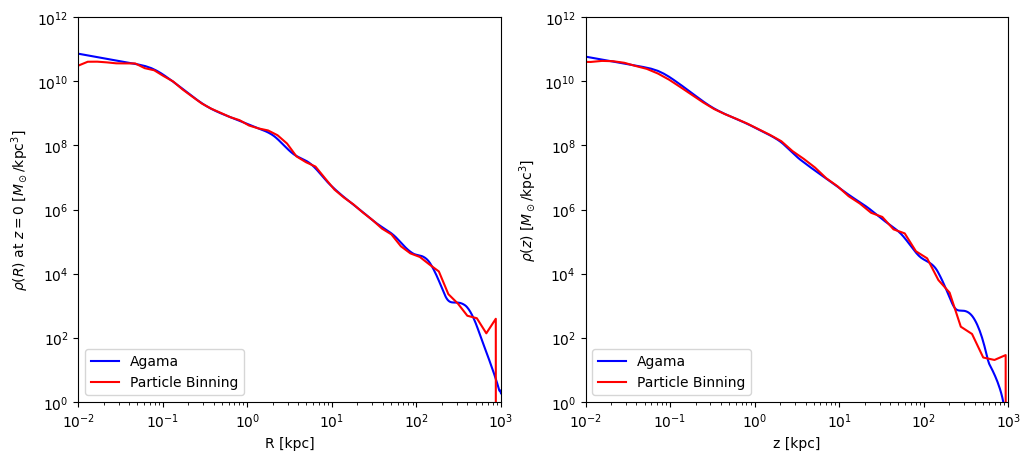

In [29]:
ax = plt.subplots(1, 2, figsize=(12, 5))[1]
ax[0].loglog(gridR, pot_nbody.density(gridR00), label="Agama", color="blue")
# ax[0].loglog(rad_lst, pot_nbody.density(R_trial), label="Agama", color="blue")
ax[0].loglog(rad_lst, r_density_lst, label="Particle Binning", color="red")

ax[0].set_xlabel("R [kpc]")
ax[0].set_ylabel(r"$\rho(R)$ at $z=0$ $[M_\odot/\mathsf{kpc}^3]$")
ax[0].legend(loc="lower left")
ax[0].set_xlim(1e-2, 1e3)
ax[0].set_ylim(1, 1e12)

ax[1].loglog(gridz, pot_nbody.density(grid00z), label="Agama", color="blue")
# ax[1].loglog(z_lst, pot_nbody.density(z_trial), label="Agama", color="blue")
ax[1].loglog(z_lst, z_density_lst, label="Particle Binning", color="red")

ax[1].set_xlabel("z [kpc]")
ax[1].set_ylabel(r"$\rho(z)$ $[M_\odot/\mathsf{kpc}^3]$")
ax[1].legend(loc="lower left")
ax[1].set_xlim(1e-2, 1e3)
ax[1].set_ylim(1, 1e12)


In [180]:
# read Agama/py/example_actions_nbody.py

if len(str(idx)) == 3:
    file_idx = str(idx)
elif len(str(idx)) == 2:
    file_idx = "0" + str(idx)

pot_file = "snap_" + file_idx + ".ini"
pot_path = "/Users/z5114326/Documents/GitHub/GC_kinematics/data/result/m12i/potentials/"

pot_nbody.export(pot_path + pot_file)

In [181]:
# units = {"length": 1, "velocity": 1, "mass": 1}

# component_1 = {
#     "pos_limit": pos_limit_dark,
#     "ptypes": ["dark", "dark2"],
#     "type": "Multipole",
#     "symmetry": "axisymmetric",
#     "lmax": 2,
#     "mmax": 0,
#     "gridSizeR": 20,
# }

# component_2 = {
#     "pos_limit": pos_limit_bary,
#     "ptypes": ["star", "gas"],
#     "type": "CylSpline",
#     "symmetry": "axisymmetric",
#     "mmax": 0,
#     "gridSizeR": 20,
#     "gridSizeZ": 20,
# }

snap_potential = {
    "units": units,
    "snapshot": int(idx),
    "num_component": 2,
    "component_1": component_1,
    "component_2": component_2,
}

# Instead make a json file
pot_json = "snap_" + str(idx) + ".json"

with open(pot_path + pot_json, "w") as outfile:
    json.dump(snap_potential, outfile)